In [1]:
#import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

<ipython-input-1-7ed630ebb5ad>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#download dataset from uci repo
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv

--2023-04-14 05:05:10--  http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25478 (25K) [application/x-httpd-php]
Saving to: ‘forestfires.csv’

forestfires.csv     100%[===================>]  24.88K  --.-KB/s    in 0.05s   

2023-04-14 05:05:10 (528 KB/s) - ‘forestfires.csv’ saved [25478/25478]



In [3]:
#read and show dataset
df = pd.read_csv('/content/forestfires.csv')
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [4]:
#statistical detail of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [5]:
#forest fire area consideration above 6 hectere
df['size_category'] = np.where(df['area']>6, '1', '0')
df['size_category']= pd.to_numeric(df['size_category'])
df.tail(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,0
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43,0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00,0
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00,0


In [6]:
# converting to "is weekend"
df['day'] = ((df['day'] == 'sun') | (df['day'] == 'sat'))
# renaming column
df = df.rename(columns = {'day' : 'is_weekend'})

In [7]:
# converting to "is summer"
df['month'] = ((df['month'] == 'jun') | (df['month'] == 'jul') | (df['month'] == 'aug'))
# renaming column
df = df.rename(columns = {'month' : 'is_summer'})

In [8]:
#defing features and label
features = df.drop(["size_category","is_summer","is_weekend","X","Y"],axis = 1)

labels = df['size_category'].values.reshape(-1, 1)

#splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state = 42)

In [9]:
#show feature
features.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [10]:
# scaling values
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
y_test = pd.DataFrame(y_test, columns = ['size_category'])
y_train = pd.DataFrame(y_train, columns = ['size_category'])
X_test.head()
# y_train.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,-1.843925,-1.382185,-1.753655,-1.007520,-1.294117,3.352501,0.439642,-0.135002,-0.181065
1,1.544206,1.341810,0.537142,0.664288,0.460418,1.437512,0.439642,4.970541,-0.181065
2,0.312158,1.802629,0.542895,-0.279974,1.124757,-0.939716,-1.261926,-0.135002,-0.169736
3,0.989785,-0.366247,0.623858,0.911963,0.204903,0.248898,0.439642,-0.135002,-0.167617
4,1.051387,0.599873,0.610707,1.546631,1.755027,-0.873682,0.439642,-0.135002,-0.163104


In [11]:
#defining model
model = Sequential()

model.add(Dense(6, input_dim=9, activation='relu'))

model.add(Dense(6, activation='relu'))

model.add(Dense(6, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 60        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 100)

Epoch 1/100
42/42 [==============================] - 2s 9ms/step - loss: 0.6768 - accuracy: 0.6416 - val_loss: 0.6536 - val_accuracy: 0.6923
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6901 - val_loss: 0.6274 - val_accuracy: 0.7404
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.7240 - val_loss: 0.6159 - val_accuracy: 0.7308
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.7337 - val_loss: 0.6072 - val_accuracy: 0.7308
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5986 - accuracy: 0.7312 - val_loss: 0.6043 - val_accuracy: 0.7308
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5921 - accuracy: 0.7312 - val_loss: 0.5983 - val_accuracy: 0.7308
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.7312 - val_loss: 0.5926 - val_accuracy: 0.7404
Epoch 8/100
4

Evaluating

In [13]:
#evaluating model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.988, Valid: 0.962


In [14]:
y_predicted = model.predict(X_test) > 0.5

4/4 [==============================] - 0s 5ms/step


In [15]:
from sklearn.metrics import precision_score
precision_score(y_test, y_predicted)

0.9615384615384616

In [16]:
from sklearn.metrics import recall_score
recall_score(y_test, y_predicted)

0.8928571428571429

In [17]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predicted)

0.9259259259259259

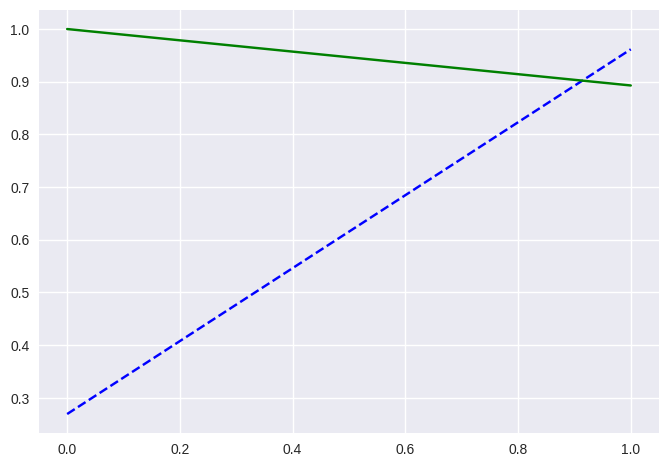

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_predicted)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()

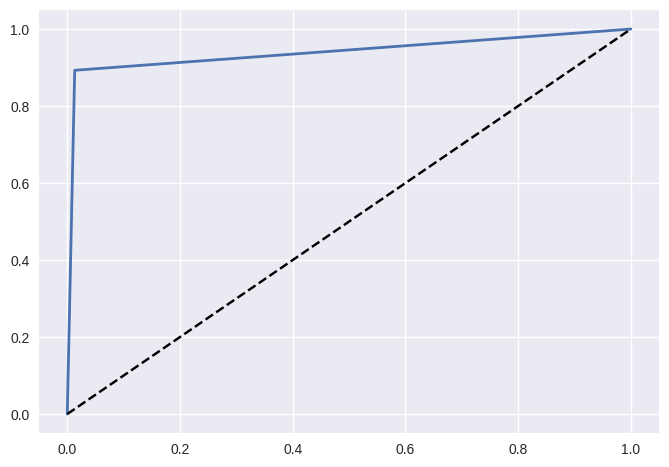

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
label = ['Area Max', 'Area Min']
plt.plot(fpr, tpr, linewidth=2, label=label)
plt.plot([0, 1], [0, 1], 'k--') 
plt.show()

Text(168.97222222222223, 0.5, 'Actual label')

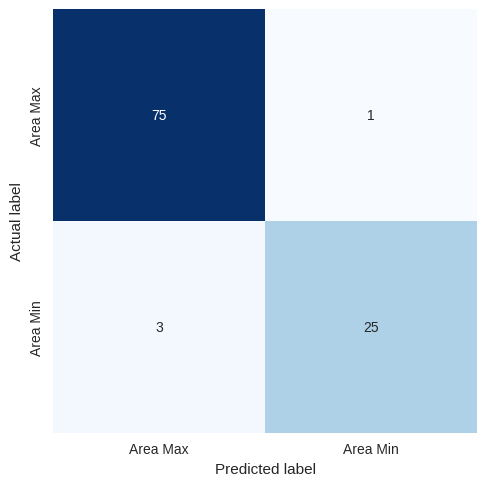

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test, y_predicted)
labels = ['Area Max', 'Area Min']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

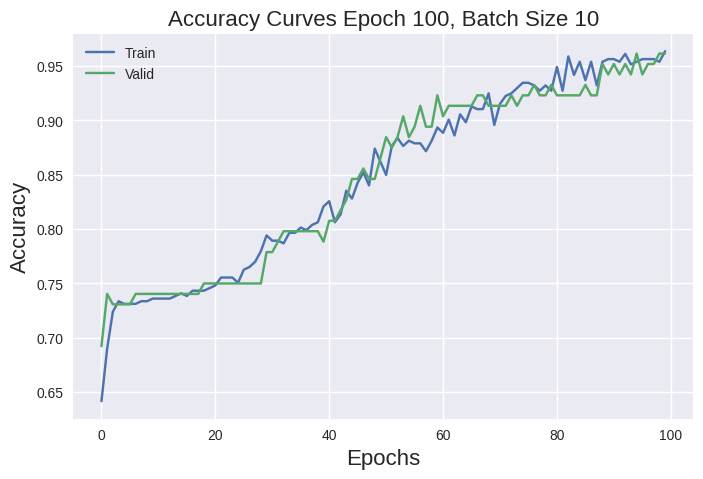

In [21]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()

Experimenting with batch size


Train: 0.995, Valid: 0.962
4/4 [==============================] - 0s 5ms/step
Precision for batch=4 0.9615384615384616
Recall for batch=4 0.8928571428571429
F1 Score for batch=4 0.9259259259259259 


Train: 0.985, Valid: 0.942
4/4 [==============================] - 0s 5ms/step
Precision for batch=6 0.9230769230769231
Recall for batch=6 0.8571428571428571
F1 Score for batch=6 0.888888888888889 


Train: 0.990, Valid: 0.923
4/4 [==============================] - 0s 4ms/step
Precision for batch=10 0.9166666666666666
Recall for batch=10 0.7857142857142857
F1 Score for batch=10 0.8461538461538461 


Train: 0.913, Valid: 0.875
4/4 [==============================] - 0s 4ms/step
Precision for batch=16 0.8947368421052632
Recall for batch=16 0.6071428571428571
F1 Score for batch=16 0.7234042553191489 


Train: 0.896, Valid: 0.875
4/4 [==============================] - 0s 5ms/step
Precision for batch=32 1.0
Recall for batch=32 0.5357142857142857
F1 Score for batch=32 0.6976744186046512 


Train:

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


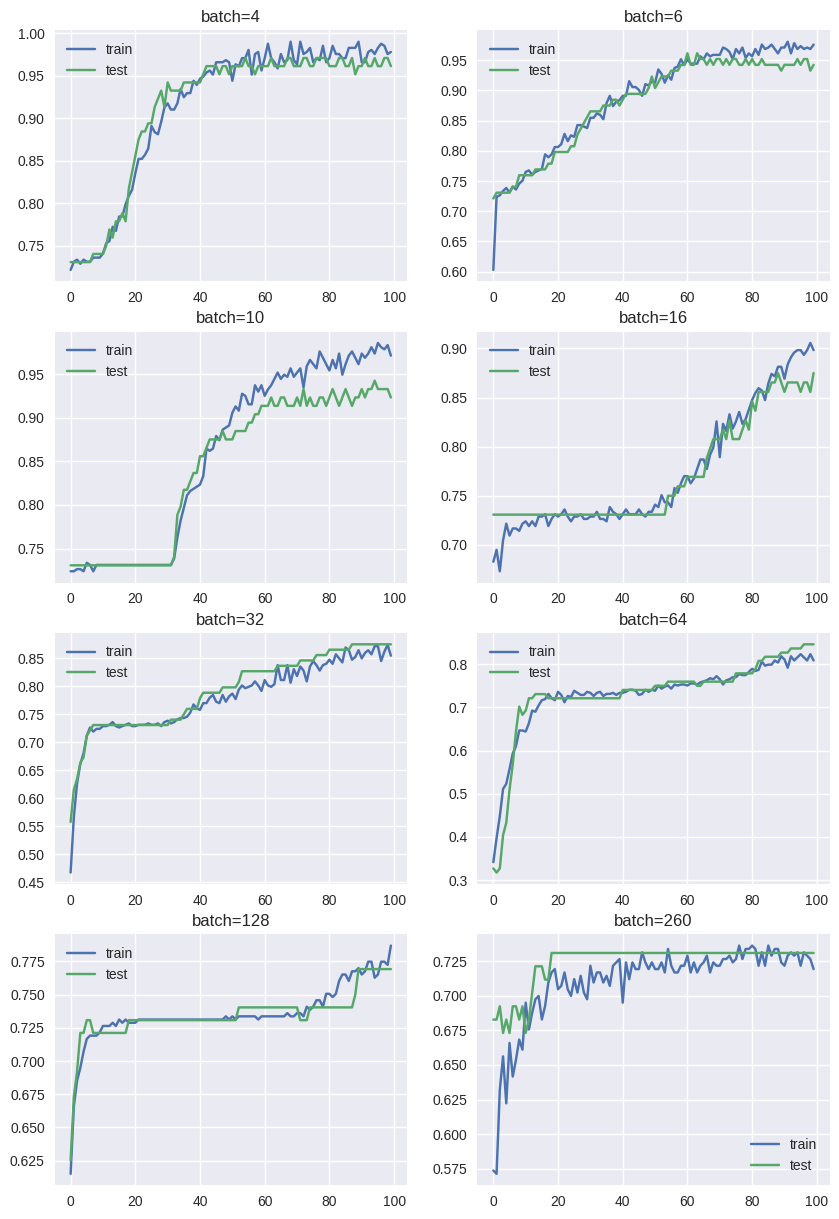

In [23]:

def fit_model(X_train, y_train, X_test, y_test, n_batch):

  model = Sequential()
  model.add(Dense(6, input_dim=9, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(optimizer = 'adam',
  metrics=['accuracy'],
  loss = 'binary_crossentropy')

  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0, batch_size=n_batch)

  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, valid_acc = model.evaluate(X_test, y_test, verbose=0)
  print('\nTrain: %.3f, Valid: %.3f' % (train_acc, valid_acc))
  y_predicted = model.predict(X_test) > 0.5
  print("Precision for batch="+str(n_batch),precision_score(y_test, y_predicted))
  print("Recall for batch="+str(n_batch),recall_score(y_test, y_predicted))
  print("F1 Score for batch="+str(n_batch),f1_score(y_test, y_predicted),"\n")

  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('batch='+str(n_batch))
  plt.legend()

batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  fit_model(X_train, y_train, X_test, y_test, batch_sizes[i])
 
plt.show()

Experimenting with Epoch number


Train: 0.782, Valid: 0.760
4/4 [==============================] - 0s 4ms/step
Precision for batch=20 0.7142857142857143
Recall for batch=20 0.17857142857142858
F1 Score for batch=20 0.2857142857142857 


Train: 0.881, Valid: 0.875
4/4 [==============================] - 0s 4ms/step
Precision for batch=50 0.8571428571428571
Recall for batch=50 0.6428571428571429
F1 Score for batch=50 0.7346938775510204 


Train: 0.998, Valid: 0.981
4/4 [==============================] - 0s 4ms/step
Precision for batch=100 1.0
Recall for batch=100 0.9285714285714286
F1 Score for batch=100 0.962962962962963 


Train: 0.998, Valid: 0.962
4/4 [==============================] - 0s 3ms/step
Precision for batch=120 0.9285714285714286
Recall for batch=120 0.9285714285714286
F1 Score for batch=120 0.9285714285714286 


Train: 0.995, Valid: 0.981
4/4 [==============================] - 0s 3ms/step
Precision for batch=150 1.0
Recall for batch=150 0.9285714285714286
F1 Score for batch=150 0.962962962962963 


Train:

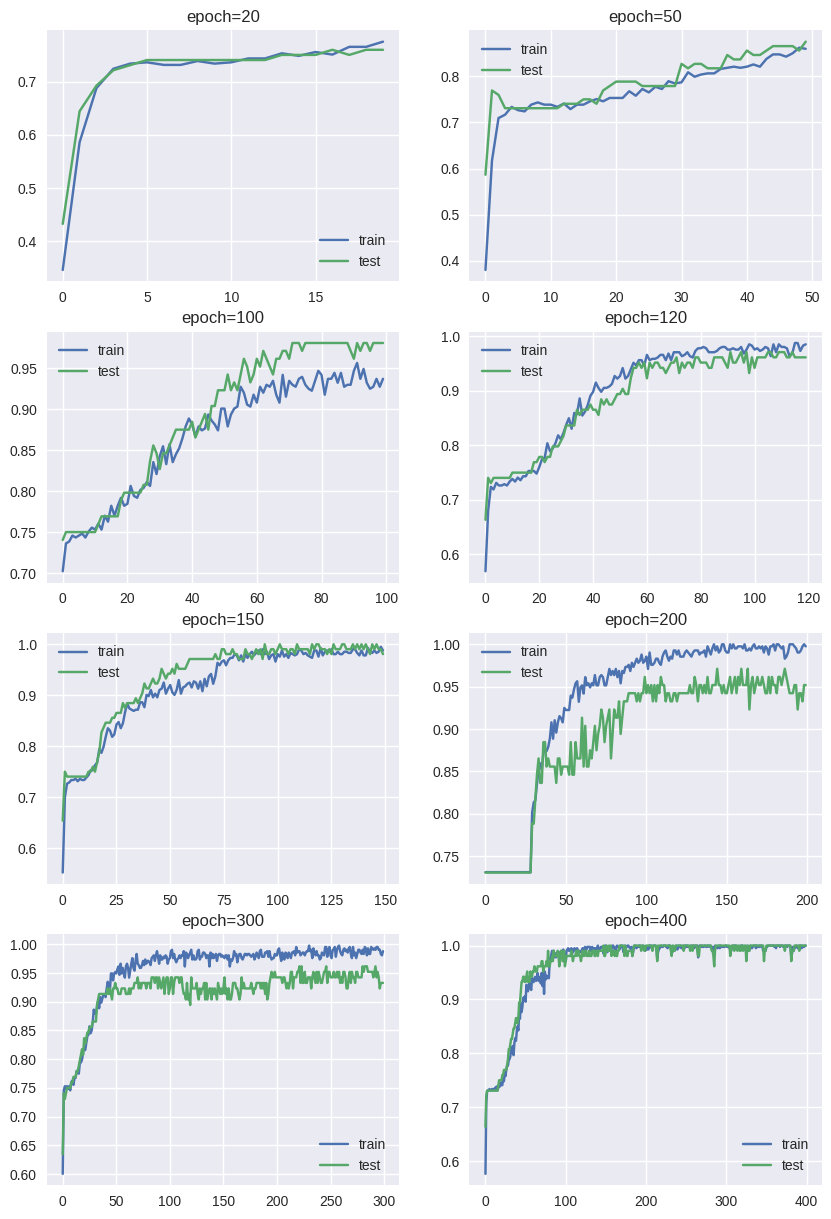

In [75]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, validX, validy, n_epoch):
  # define model
  model = Sequential()
  model.add(Dense(6, input_dim=9, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))
  # compile model
  model.compile(optimizer ='adam', metrics=['accuracy'], loss = 'binary_crossentropy')
  # fit model
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=n_epoch, verbose=0, batch_size=6)

  #evaluating
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, valid_acc = model.evaluate(X_test, y_test, verbose=0)
  print('\nTrain: %.3f, Valid: %.3f' % (train_acc, valid_acc))
  y_predicted = model.predict(X_test) > 0.5
  print("Precision for batch="+str(n_epoch),precision_score(y_test, y_predicted))
  print("Recall for batch="+str(n_epoch),recall_score(y_test, y_predicted))
  print("F1 Score for batch="+str(n_epoch),f1_score(y_test, y_predicted),"\n")

  # plot learning curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('epoch='+str(n_epoch))
  plt.legend()

# Create learning curves for different batch sizes
epochs = [20, 50, 100, 120, 150, 200, 300, 400]
plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):
  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)
  # Fit model and plot learning curves for a batch size
  fit_model(X_train, y_train, X_test, y_test, epochs[i])
  # Show learning curves
plt.show()


In [24]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay

In [39]:
## RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=2,random_state=0)
RF.fit(X_train,y_train)

predicted_values = RF.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)
print("RF's Accuracy is: ", x*100)

print(classification_report(y_test,predicted_values))

RF's Accuracy is:  97.11538461538461
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        76
           1       1.00      0.89      0.94        28

    accuracy                           0.97       104
   macro avg       0.98      0.95      0.96       104
weighted avg       0.97      0.97      0.97       104



<ipython-input-39-70cb004b9a97>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


In [40]:
## SVM

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)
SVM = SVC()
SVM.fit(X_train_norm,y_train)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(y_test, predicted_values)

print("SVM's Accuracy is: ", x*100)

print(classification_report(y_test,predicted_values))

SVM's Accuracy is:  75.0
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        76
           1       1.00      0.07      0.13        28

    accuracy                           0.75       104
   macro avg       0.87      0.54      0.49       104
weighted avg       0.81      0.75      0.66       104



/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
## DECISION TREE

from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(random_state=42,max_depth=3,min_impurity_decrease=0.4)

DecisionTree.fit(X_train,y_train)

predicted_values = DecisionTree.predict(X_test)
x = metrics.accuracy_score(y_test, predicted_values)

print("DecisionTrees's Accuracy is: ", x*100)

print(classification_report(y_test,predicted_values))

DecisionTrees's Accuracy is:  73.07692307692307
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        76
           1       0.00      0.00      0.00        28

    accuracy                           0.73       104
   macro avg       0.37      0.50      0.42       104
weighted avg       0.53      0.73      0.62       104



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
## LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()

LogReg.fit(X_train,y_train)

predicted_values = LogReg.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)
print("Logistic Regression's Accuracy is: ", x*100)

print(classification_report(y_test,predicted_values))

Logistic Regression's Accuracy is:  85.57692307692307
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        76
           1       1.00      0.46      0.63        28

    accuracy                           0.86       104
   macro avg       0.92      0.73      0.77       104
weighted avg       0.88      0.86      0.84       104



/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
HENCE SEQUENTIAL HAS HIGHEST ACCURACY WITH EPOCH AS 400 SO WE ARE CHOOSING IT AS OUT BASE MODEL

In [76]:

import pickle
pkl_filename = 'Final_Model.pkl'
pkl = open(pkl_filename,'wb')
pickle.dump(model,pkl)
pkl.close()

In [89]:
data = np.array([[93.5,149.3,728.6,8.1,17.2,43,3.1,0,0]])
pred = model.predict(data)
print(int(pred[0][0]))

1/1 [==============================] - 0s 30ms/step
1
